In [3]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


from jcopml.tuning import random_search_params as rsp
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning.space import Integer, Real


pd.options.display.max_columns = 100

In [4]:
df = pd.read_csv("data/breast_cancer.csv")
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [5]:
df.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [6]:
df.target.value_counts(normalize=True)

1.0    0.627417
0.0    0.372583
Name: target, dtype: float64

In [7]:
X = df.drop(columns=["target"])
y = df.target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((381, 30), (188, 30), (381,), (188,))

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

- jumlah komponen 2 supaya bisa diplot dan kita bisa tau datanya seperti apa
- whiten = True, istilah lain standard scaller di PCA

In [15]:
pca = PCA(n_components=2, whiten=True) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



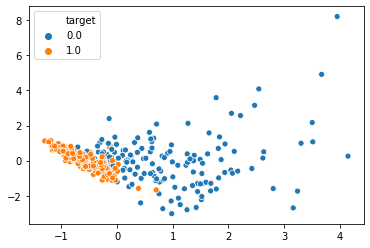

In [17]:
sns.scatterplot(X_train_pca[:, 0], X_train_pca[:, 1], hue=y_train);

In [27]:
# pipeline.get_params() untuk mengetahui apa aja yg bisa dituning'

In [24]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("pca", PCA()),
    ("algo", SVC(max_iter=500))
])

parameter = {
    'pca__n_components': Integer(1, 30),
    'pca__whiten': [True, False],
    'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
    'algo__C': Real(low=-3, high=3, prior='log-uniform')
}

model = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print("score train : ", model.score(X_train, y_train))
print("score test  : ", model.score(X_test, y_test))





Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s


{'algo__C': 146.0103021015953, 'algo__gamma': 0.0011008110571039537, 'pca__n_components': 8, 'pca__whiten': True}
score train :  0.9606299212598425
score test  :  0.9574468085106383


[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished


### Teknik lain untuk menentukan n_components -> Cumulative Explained Varianced

- dari hasil plot ini kita bisa simpulkan kalo fiturnya kita reduce kecil pun masih bisa mempertahankan informasi 98% artinya apa
- fiturnya banyak yg gabermakna / maknanya sama
- banyak yg mubazir yaa gayss yaaa

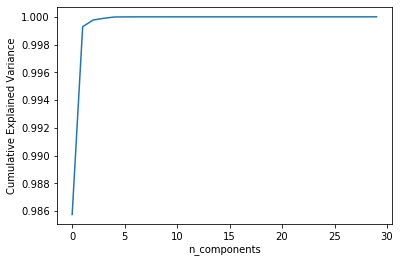

In [11]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("n_components")
plt.ylabel("Cumulative Explained Variance");